L1 dist, with regularization `0.1`: `0.4525`  
L1 dist, with regularization `2e-4`:   
L1 dist, without regularization: `0.6075`  
L2 dist, without regularization: `0.41`  
L2 dist, with regularization `2e-4`: `0.4450`

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os
from os.path import join
from tqdm import tqdm, trange

In [3]:
src = 'data/original/images_evaluation'
alphabet = 'Angelic'
src = 'data/original/images_background'
alphabet = 'Alphabet_of_the_Magi'
folders = [join(src, alphabet, f) for f in os.listdir(join(src, alphabet))]
files = [[join(src, f) for f in os.listdir(src)] for src in folders]
len(files), len(files[0])

(20, 20)

In [4]:
images = ~np.array([[cv2.imread(f, 0) for f in l] for l in files]) / 255
images.shape

(20, 20, 105, 105)

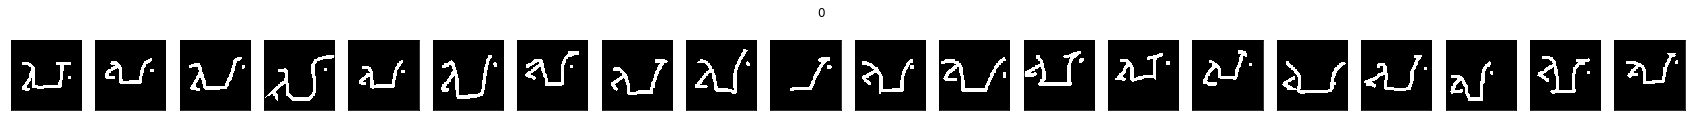

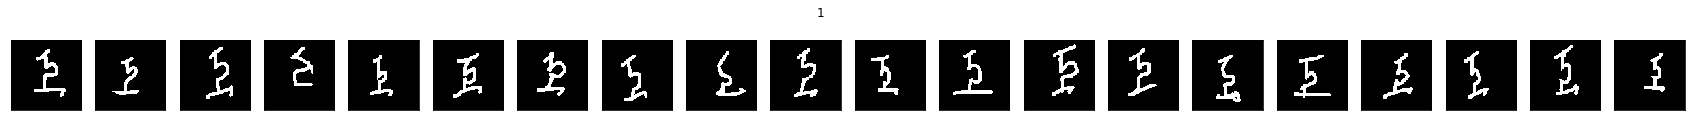

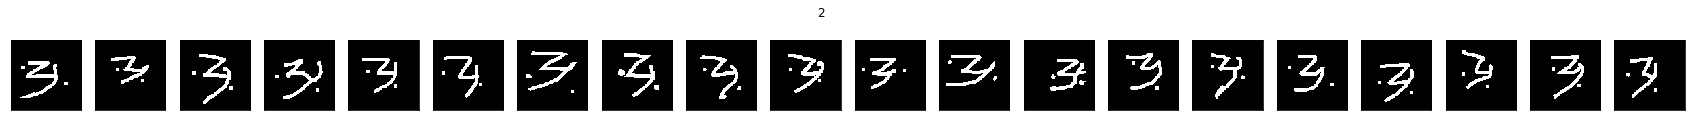

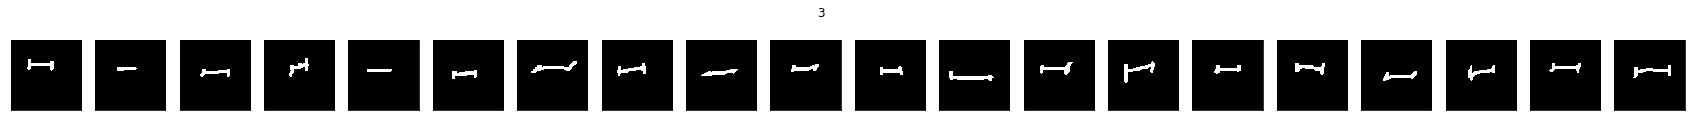

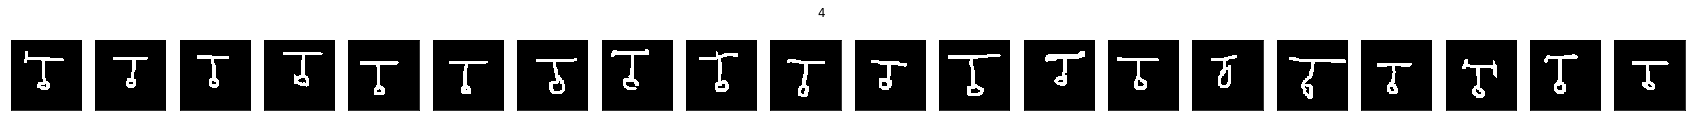

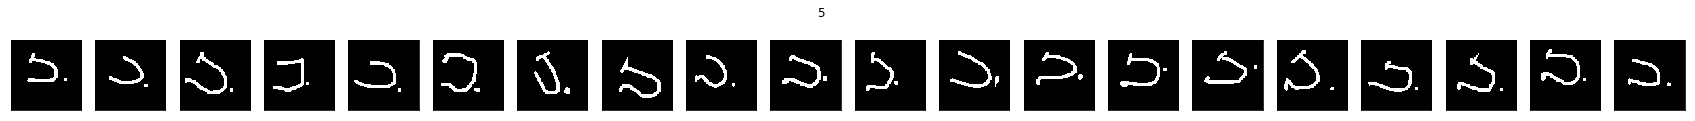

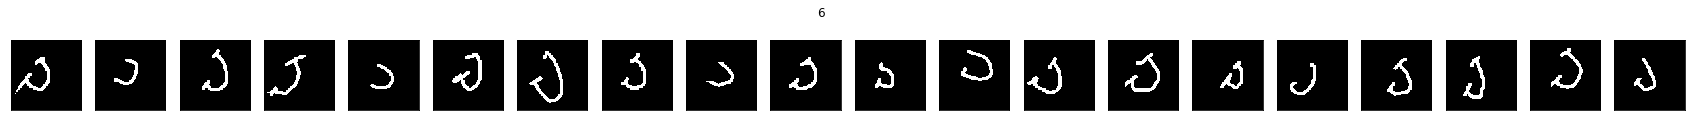

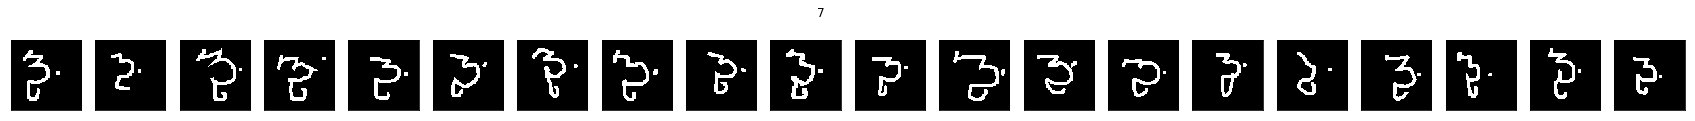

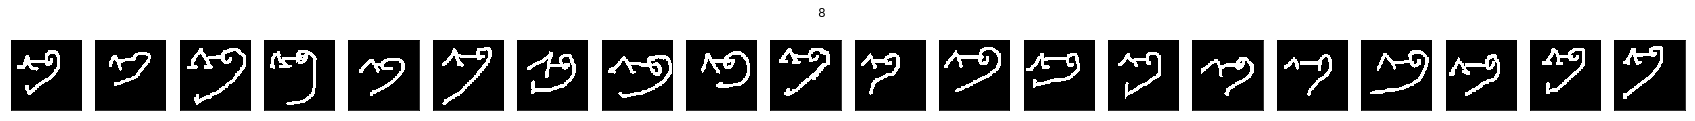

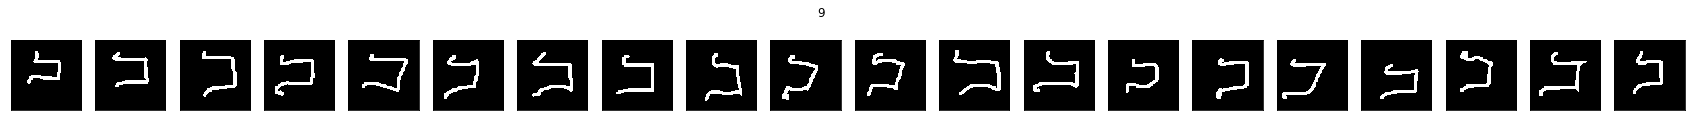

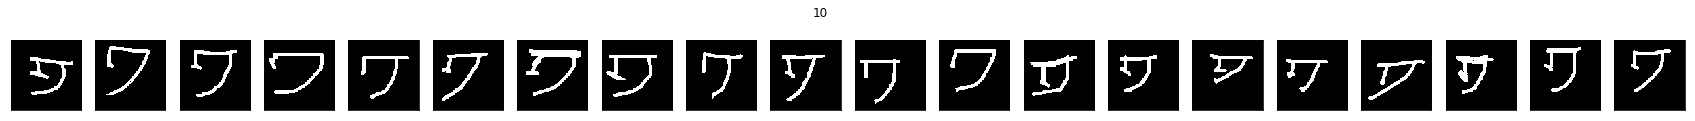

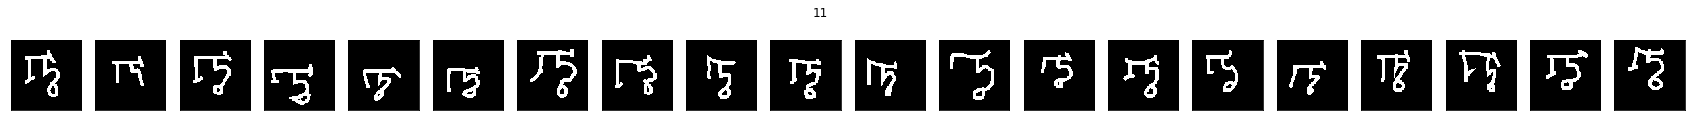

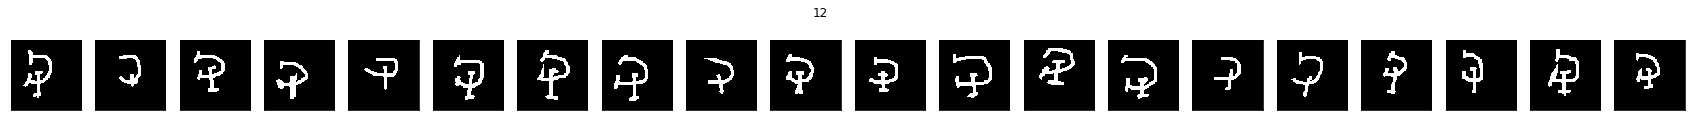

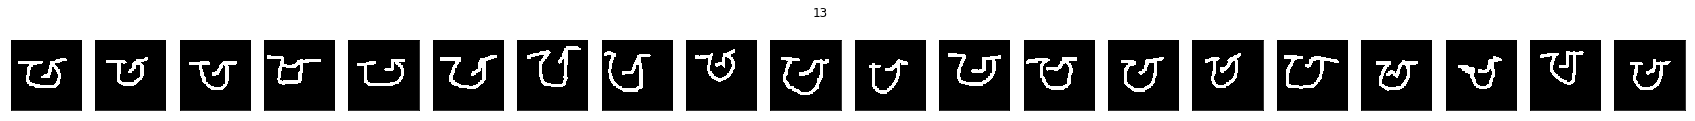

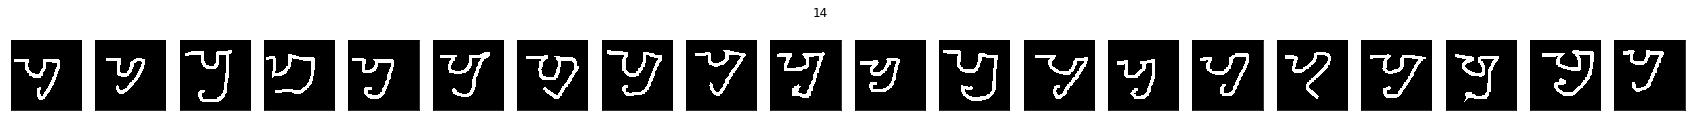

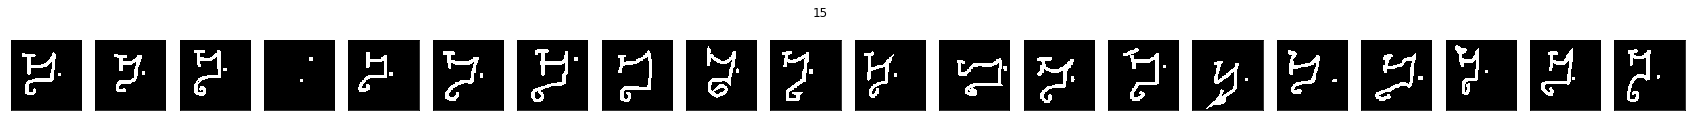

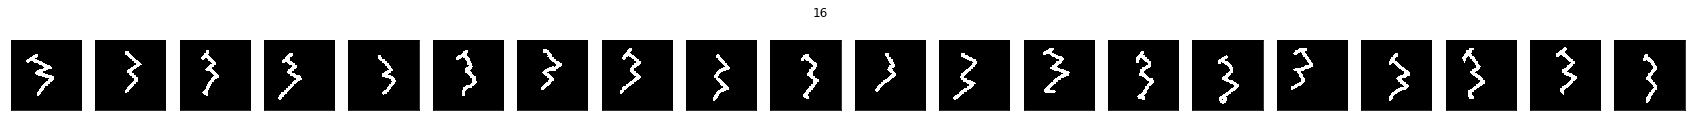

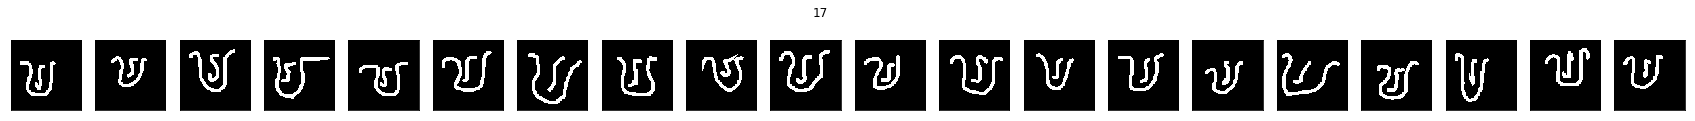

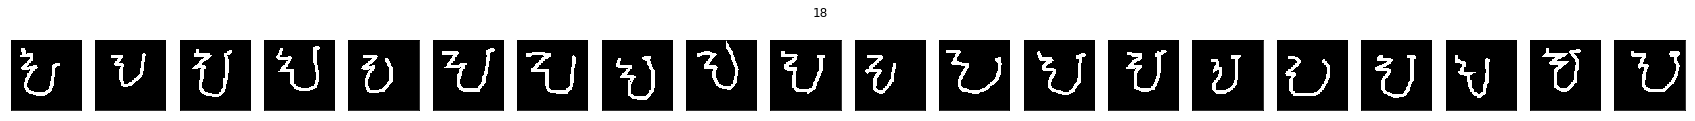

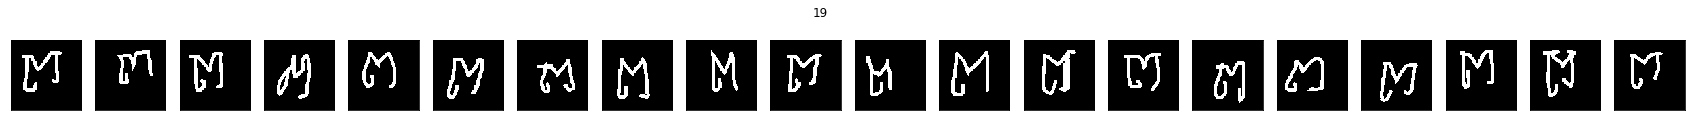

In [5]:
for i, l in enumerate(images):
    plt.figure(figsize=(30, 2))
    plt.suptitle(i)
    for j, image in enumerate(l):
        plt.subplot(1, len(l), j+1)
        plt.xticks([]), plt.yticks([])
        plt.imshow(image, cmap='gray')

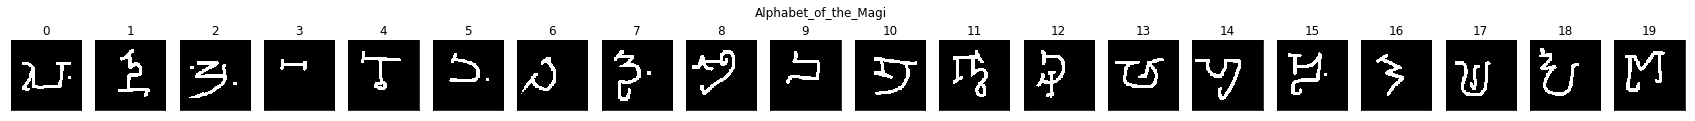

In [6]:
ground = images[:, 0]

plt.figure(figsize=(30, 2))
plt.suptitle(alphabet)
for i, image in enumerate(ground):
    plt.subplot(1, len(images), i+1)
    plt.title(i)
    plt.xticks([]), plt.yticks([])
    plt.imshow(image, cmap='gray')

In [7]:
from siamese import Siamese
model = Siamese()

In [8]:
model_path = 'model/omniglot/model'

saver = tf.train.Saver()
sess = tf.Session()
saver.restore(sess, model_path)

INFO:tensorflow:Restoring parameters from model/omniglot/model


In [9]:
preds = [[] for _ in images]

with trange(len(images)) as pbar:
    for i in pbar:
        for j, image in enumerate(images[i]):
            feed_dict = {
                model.x1: np.expand_dims([image for _ in ground], axis=-1),
                model.x2: np.expand_dims(ground, axis=-1),
                model.keep_prob: 1.0
            }
            sigmoid = sess.run(model.out, feed_dict)
            pred = np.argmax(sigmoid)
            preds[i].append(pred)
            
            pbar.set_postfix(count=j+1)

100%|████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.23s/it, count=20]


In [10]:
from sklearn.metrics import confusion_matrix
y_true = np.array([[i for _ in images[i]] for i in range(len(images))]).flatten()
y_preds = np.array(preds).flatten()
cm = confusion_matrix(y_true, y_preds)

Confusion matrix, without normalization


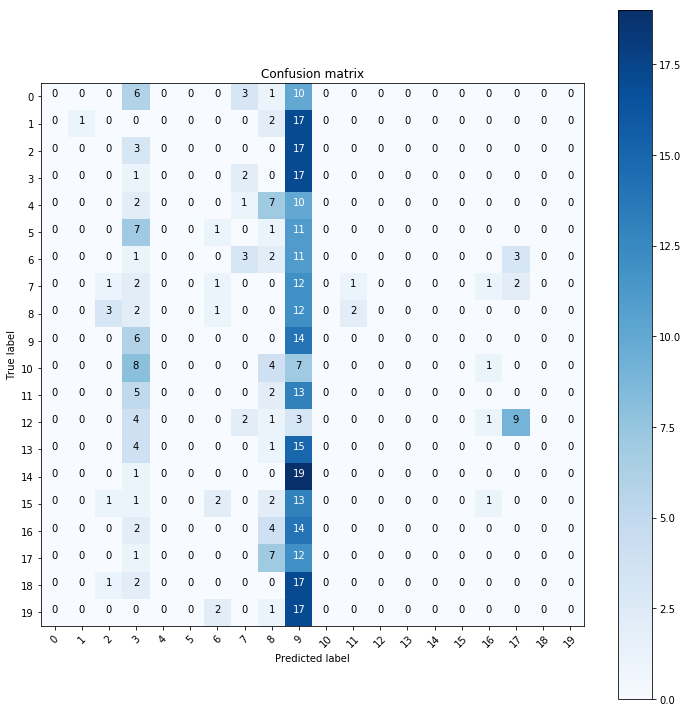

In [11]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
plot_confusion_matrix(cm, np.arange(20))

In [12]:
tp = np.eye(len(cm)) * cm
np.sum(tp) / np.sum(cm)

0.04